# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy import stats as st
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
data0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
data0.duplicated().sum()

0


Распределение признаков:


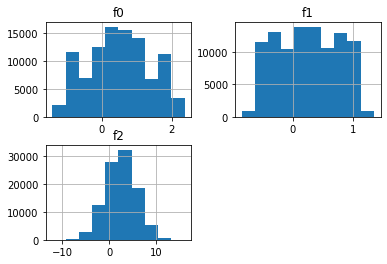

In [7]:
print('\nРаспределение признаков:')
data0[['f0','f1','f2']].hist()
plt.show()

In [8]:
print('Корреляция0:')
print(data0['f0'].corr(data0['product']))
print(data0['f1'].corr(data0['product']))
print(data0['f2'].corr(data0['product']))

Корреляция0:
0.14353635093189274
-0.19235576281513284
0.4836632869261524


In [9]:
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
data1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [12]:
data1.duplicated().sum()

0


Распределение признаков:


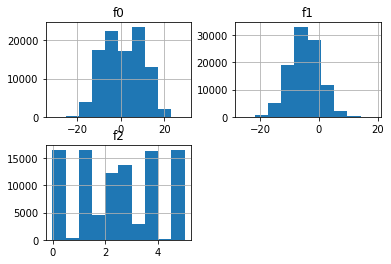

In [13]:
print('\nРаспределение признаков:')
data1[['f0','f1','f2']].hist()
plt.show()

In [14]:
print('Корреляция1:')
print(data1['f0'].corr(data1['product']))
print(data1['f1'].corr(data1['product']))
print(data1['f2'].corr(data1['product']))

Корреляция1:
-0.030490530564375246
-0.010154931786466113
0.9993969704906555


In [15]:
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [16]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [17]:
data2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [18]:
data2.duplicated().sum()

0


Распределение признаков:


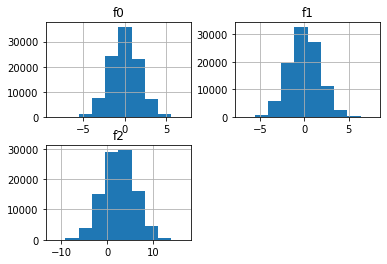

In [19]:
print('\nРаспределение признаков:')
data2[['f0','f1','f2']].hist()
plt.show()

In [20]:
print('Корреляция2:')
print(data2['f0'].corr(data2['product']))
print(data2['f1'].corr(data2['product']))
print(data2['f2'].corr(data2['product']))

Корреляция2:
-0.001987061999049139
-0.0010123938161309028
0.4458710915574209


Все датасеты не имеют пропусков, отсутствуют дубликаты.

Признак f2 показывает наличие связи с объем запасов в скважине во всех трех регионах, особенно сильное влияние во втором регионе.

## Обучение и проверка модели

In [21]:
# Разбиение данных на обучающую и валидационную выборки
data0_train, data0_valid = train_test_split(data0, test_size=0.25, random_state=12345)

In [22]:
data1_train, data1_valid = train_test_split(data1, test_size=0.25, random_state=12345)

In [23]:
data2_train, data2_valid = train_test_split(data2, test_size=0.25, random_state=12345)

In [24]:
# создаем переменные для признаков и целевого признака
features_train0 = data0_train.drop(['product','id'], axis=1)
target_train0 = data0_train['product']
features_valid0 = data0_valid.drop(['product','id'], axis=1)
target_valid0 = data0_valid['product']

In [25]:
model0 = LinearRegression()# инициализируем модель LinearRegression
model0.fit(features_train0,target_train0) # обучаем модель на тренировочной выборке
predictions_valid0 = model0.predict(features_valid0) # получаем предсказания модели на валидационной выборке

In [26]:
features_train1 = data1_train.drop(['product','id'], axis=1)
target_train1 = data1_train['product']
features_valid1 = data1_valid.drop(['product','id'], axis=1)
target_valid1 = data1_valid['product']

In [27]:
model1 = LinearRegression()
model1.fit(features_train1,target_train1)
predictions_valid1 = model1.predict(features_valid1)

In [28]:
features_train2 = data2_train.drop(['product','id'], axis=1)
target_train2 = data2_train['product']
features_valid2 = data2_valid.drop(['product','id'], axis=1)
target_valid2 = data2_valid['product']

In [29]:
model2 = LinearRegression()
model2.fit(features_train2,target_train2)
predictions_valid2 = model2.predict(features_valid2)

In [30]:
mse0 = mean_squared_error(target_valid0, predictions_valid0)
mse1 = mean_squared_error(target_valid1, predictions_valid1)
mse2 = mean_squared_error(target_valid2, predictions_valid2)

In [31]:
print('Linear Regression0:', 'MSE0 =', mse0, ', RMSE0 =', mse0 ** 0.5)
print('Linear Regression1:', 'MSE1 =', mse1, ', RMSE1 =', mse1 ** 0.5)
print('Linear Regression2:', 'MSE2 =', mse2, ', RMSE2 =', mse2 ** 0.5)

Linear Regression0: MSE0 = 1412.2129364399243 , RMSE0 = 37.5794217150813
Linear Regression1: MSE1 = 0.7976263360391157 , RMSE1 = 0.893099286775617
Linear Regression2: MSE2 = 1602.3775813236196 , RMSE2 = 40.02970873393434


In [32]:
# средний запас предсказанного сырья
print('average_product0 =', sum(predictions_valid0) / len(predictions_valid0))
print('average_product1 =', sum(predictions_valid1) / len(predictions_valid1))
print('average_product2 =', sum(predictions_valid2) / len(predictions_valid2))

average_product0 = 92.59256778438008
average_product1 = 68.7285468954458
average_product2 = 94.96504596800506


Модель 1 имеет самый низкий RMSE =  0.893, что говорит нам о том, что она способна лучше всего соответствовать набору данных из трех потенциальных моделей.

## Подготовка к расчёту прибыли

In [33]:
budget = 10000000 #Бюджет на разработку скважин в регионе, тыс.руб
income_one_prod = 450 #Доход с каждой единицы продукта, тыс.руб
target_probability_losses = 2.5/100 # вероятность убытков
product_mean_0 = data0['product'].mean()
product_mean_1 = data1['product'].mean()
product_mean_2 = data2['product'].mean()

In [34]:
budg_per_1_point=(budget/200)# тыс.руб
print('Бюджет на разработку одной скважины:', budg_per_1_point/1000,'млн.руб')

Бюджет на разработку одной скважины: 50.0 млн.руб


In [35]:
v_prod=budg_per_1_point/income_one_prod
print('Объём каждой скважины для безубыточной разработки должен составлять не менее: %.2f'%v_prod,'тыс.баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11 тыс.баррелей


In [36]:
# Сравнение полученного объёма сырья со средним запасом в каждом регионе
data0['profit']=(data0['product']*(income_one_prod)).round(2) # profit, тыс.руб
data0.head()

,id,f0,f1,f2,product,profit
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49


In [37]:
data1['profit']=(data1['product']*(income_one_prod)).round(2) # profit, тыс.руб
data1.head()

,id,f0,f1,f2,product,profit
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84


In [38]:
data2['profit']=(data2['product']*(income_one_prod)).round(2) # profit, тыс.руб
data0.head()

,id,f0,f1,f2,product,profit
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49


In [39]:
# Определим значение ROI для каждой скважины по отношению к затратам на разработку
data0['roi_%']=((data0['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data0.head()

,id,f0,f1,f2,product,profit,roi_%
0,txEyH,0.705745,-0.497823,1.221170,105.280062,47376.03,-5.25
1,2acmU,1.334711,-0.340164,4.365080,73.037750,32866.99,-34.27
2,409Wp,1.022732,0.151990,1.419926,85.265647,38369.54,-23.26
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,75879.35,51.76
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,69316.49,38.63


In [40]:
data1['roi_%']=((data1['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data1.head()

,id,f0,f1,f2,product,profit,roi_%
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103,1430.60,-97.14
1,62mP7,14.272088,-3.475083,0.999183,26.953261,12128.97,-75.74
2,vyE1P,6.263187,-5.948386,5.001160,134.766305,60644.84,21.29
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408,62075.43,24.15
4,AHL4O,12.702195,-8.147433,5.004363,134.766305,60644.84,21.29


In [41]:
data2['roi_%']=((data2['profit']-budg_per_1_point)/budg_per_1_point*100).round(2)
data2.head()

,id,f0,f1,f2,product,profit,roi_%
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673,12491.40,-75.02
1,WJtFt,0.262778,0.269839,-2.530187,56.069697,25231.36,-49.54
2,ovLUW,0.194587,0.289035,-5.586433,62.871910,28292.36,-43.42
3,q6cA6,2.236060,-0.553760,0.930038,114.572842,51557.78,3.12
4,WPMUX,-0.515993,1.716266,5.899011,149.600746,67320.34,34.64


In [42]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: {:.2%}'.format(product_mean_0/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean_0))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 1 региону составляет: -16.75%
Или 18.61 тыс.баррелей


In [43]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: {:.2%}'.format(product_mean_1/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean_1))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 2 региону составляет: -38.06%
Или 42.29 тыс.баррелей


In [44]:
print('Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: {:.2%}'.format(product_mean_2/v_prod-1))
print('Или {:.2f} тыс.баррелей'.format(v_prod-product_mean_2))

Разница объёма сырья для безубыточной разработки скважины относительно среднего значения по 3 региону составляет: -14.50%
Или 16.11 тыс.баррелей


Исходя из полученных данных становится очевидно, что среднее количество запасов сырья по регионам недостаточное даже для окупаемости разработки, требуется выбрать скважины с максимальными запасами

## Расчёт прибыли и рисков 

## Чек-лист готовности проекта

In [45]:
# Выберем скважины с максимальными значениями предсказаний
predictions_valid0

array([ 95.89495185,  77.57258261,  77.89263965, ...,  61.50983303,
       118.18039721, 118.16939229])

In [46]:
# Выполним привязку индексов скважин к предсказаниям модели и отсорируем список по убыванию
probs_sorted_0 = pd.Series(predictions_valid0, index=target_valid0.index).sort_values(ascending=False)
selected_max_0 = probs_sorted_0[:200]
selected_max_0

93073    180.180713
46784    176.252213
78948    175.850623
43388    175.658429
6496     173.299686
            ...    
30488    148.507064
98799    148.481767
53840    148.476498
4638     148.436761
75908    148.365941
Length: 200, dtype: float64

In [47]:
selected_max_0_sum = selected_max_0.sum()
print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max_0_sum)

Суммарный запас сырья в 200 лучших скважинах составит: 31102.33 тыс.баррелей


In [48]:
profit_pred_0=(selected_max_0_sum*income_one_prod)-budget
print('Прибыль для полученного объёма сырья составит %.2f тыс.рублей'%profit_pred_0)

Прибыль для полученного объёма сырья составит 3996048.88 тыс.рублей


In [49]:
def profit_for_vp(predict,target,count):
    probs_sorted = pd.Series(predict, index=target.index).sort_values(ascending=False)
    selected_max = probs_sorted[:count].sum()
    profit_pred=(selected_max*income_one_prod)-budget
    print('Суммарный запас сырья в 200 лучших скважинах составит: %.2f тыс.баррелей'%selected_max)
    print('Прибыль для полученного объёма сырья составит %.2f млн.рублей'%(profit_pred/1000))

In [50]:
profit_for_vp(predictions_valid0,target_valid0,200)

Суммарный запас сырья в 200 лучших скважинах составит: 31102.33 тыс.баррелей
Прибыль для полученного объёма сырья составит 3996.05 млн.рублей


In [51]:
profit_for_vp(predictions_valid1,target_valid1,200)

Суммарный запас сырья в 200 лучших скважинах составит: 27746.03 тыс.баррелей
Прибыль для полученного объёма сырья составит 2485.71 млн.рублей


In [52]:
profit_for_vp(predictions_valid2,target_valid2,200)

Суммарный запас сырья в 200 лучших скважинах составит: 29603.90 тыс.баррелей
Прибыль для полученного объёма сырья составит 3321.75 млн.рублей


Все три региона потенциально прибыльные, для определения наиболее выгодного с точки зрения окупаемости вложений и рисков убытка проведём расчёт вероятности в следующей главе.

In [53]:
def profit_for_vp2(predict,target,count):
    probs_sorted = pd.Series(predict).sort_values(ascending=False)
    selected_points = target[probs_sorted.index][:count]
    product = selected_points.sum()
    revenue = product * income_one_prod
    return revenue - budget

In [54]:
def bootstap_1000(target,predict):
    values = []
    count=0
    state = np.random.RandomState(12345)
    predict_e = pd.Series(predict, index=target.index)
    
    for i in tqdm(range(1000)):
        target_subsample = target.sample(n=500,replace=True, random_state=state)
  
        probs_subsample = predict_e[target_subsample.index]
        values.append(profit_for_vp2(probs_subsample,target_subsample, 200))  
    for i in values:
        if i < 0:
            count +=1
            
    values = pd.Series(values)
    mean = values.mean()
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    
    plt.title('Распределение прибыли')
    values.plot(kind="hist", grid=True, figsize=(8,5))
    plt.xlabel('Прибыль, тыс.руб')
    plt.ylabel('Количество')
    plt.show()
    
    low_95 = values.quantile(0.025)
    high_95 = values.quantile(0.975)
    
    print("Средняя прибыль: {:.2f} млн.руб".format(mean/1000))
    print('С вероятностью 95% прибыль в данном регионе будет составлять от: {:.2f} млн.руб до: {:.2f} млн.руб'.format((low_95/1000),(high_95/1000)))
    print("95%-ый доверительный интервал: от {:.2f} млн.руб до {:.2f} млн.руб". format((confidence_interval[0]/1000),(confidence_interval[1]/1000)))
    print ('Процент вероятности убытка в данном регионе составит {:.1%}'.format(count/1000))

  0%|          | 0/1000 [00:00<?, ?it/s]

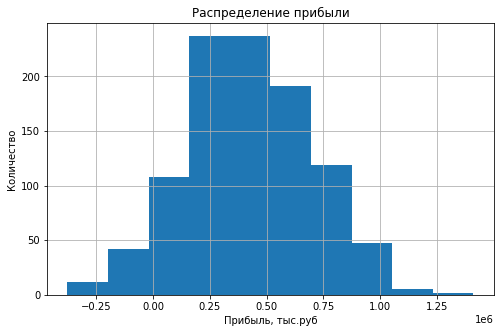

Средняя прибыль: 425.94 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -102.09 млн.руб до: 947.98 млн.руб
95%-ый доверительный интервал: от 408.73 млн.руб до 443.14 млн.руб
Процент вероятности убытка в данном регионе составит 6.0%


In [55]:
bootstap_1000(target_valid0,predictions_valid0)

  0%|          | 0/1000 [00:00<?, ?it/s]

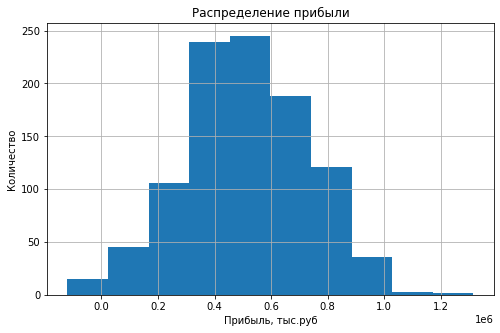

Средняя прибыль: 515.22 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: 68.87 млн.руб до: 931.55 млн.руб
95%-ый доверительный интервал: от 501.62 млн.руб до 528.82 млн.руб
Процент вероятности убытка в данном регионе составит 1.0%


In [56]:
bootstap_1000(target_valid1,predictions_valid1)

  0%|          | 0/1000 [00:00<?, ?it/s]

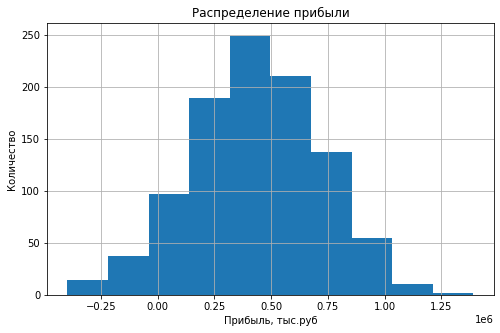

Средняя прибыль: 435.01 млн.руб
С вероятностью 95% прибыль в данном регионе будет составлять от: -128.88 млн.руб до: 969.71 млн.руб
95%-ый доверительный интервал: от 417.45 млн.руб до 452.56 млн.руб
Процент вероятности убытка в данном регионе составит 6.4%


In [57]:
bootstap_1000(target_valid2,predictions_valid2)

Сравним среднюю прибыль, вероятность убытка и суммарный запас сырья трёх представленных регионов в таблице

In [58]:
comparison_tabl = pd.DataFrame(index=['Средняя прибыль в регионе, млн.руб','Суммарный запас сырья, тыс.баррелей','Вероятность убытка, %'], columns=['1 регион','2 регион','3 регион'])
comparison_tabl['1 регион'] = '425.94', '31102.33','6.0'
comparison_tabl['2 регион'] = '515.22', '27746.03','1.0'
comparison_tabl['3 регион'] = '435.01', '29603.90','6.4'
comparison_tabl

,1 регион,2 регион,3 регион
"Средняя прибыль в регионе, млн.руб",425.94,515.22,435.01
"Суммарный запас сырья, тыс.баррелей",31102.33,27746.03,29603.90
"Вероятность убытка, %",6.0,1.0,6.4


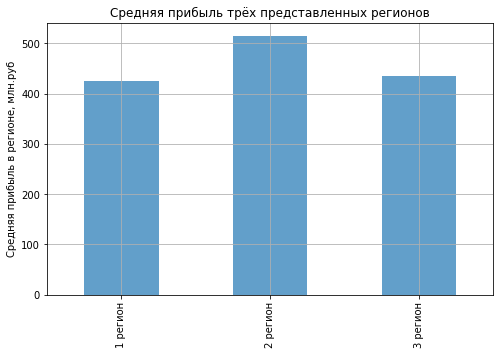

In [59]:
comparison_tabl.astype('float').iloc[0,:].plot(kind="bar", figsize=(8,5), grid=True, alpha=0.7, subplots=True)
plt.title('Средняя прибыль трёх представленных регионов')
plt.ylabel('Средняя прибыль в регионе, млн.руб')
plt.show()

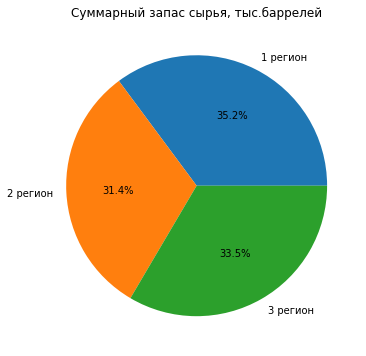

In [60]:
comparison_tabl.astype('float').iloc[1,:].plot(kind='pie', figsize=(6,6),autopct='%1.1f%%', subplots=True)
plt.title('Суммарный запас сырья, тыс.баррелей')
plt.ylabel('')
plt.show()

Согласно распределению среднего значения прибыли с региона, самым прибыльным оказался 2 регион, средняя прибыль в этом регионе составит 489.66 млн.рублей. Два других региона не прошли отбор по минимально допустимому порогу убытка в 2,5%. Таким образом не смотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами, средняя доходность со скважин во втором регионе прогнозируется выше других.

ВЫВОД:

Было проведено исследование, чтобы спрогнозировать, где бурить новую скважину. Входные данные - данные геологоразведки трёх регионов. Данные синтетические: детали контрактов и характеристики месторождений не разглашаются. Результаты исследования будут учтены бизнесом. 

В первоначальные данных наблюдалось, что средний запас ресурсов по регионам недостаточен даже для окупаемости вложений на разработку и для того, чтобы иметь уверенность в перспективе разработки по регионам. Разница объёма сырья для безубыточной разработки скважины относительно среднего значения:

1 регион составляет: -16.75%
2 регион составляет: -38.06%
3 регион составляет: -14.5%.

Фильтрация 200 скважин с максимальными значениями предсказаний по регионам показала прибыль:

1 регион: 3996.05 млн.рублей
2 регион: 2485.71 млн.рублей
3 регион: 3321.75 млн.рублей

По результату полученных данных мы определили доверительный интревал получения прибыли в 95%, ограничив вероятность убытка величиной менее 2,5%. И на основе этих данных смогли выбрать более перспективный регион для разработки 200 скважин.

После всех исследований, не смотря на сравнительно меньшие предсказания запасов сырья во втором регионе в 27746.03 тыс.баррелей (по сравнению с другими регионами), с величиной вероятного возникновения убытка в 1%, но с превышающей средней прибылью, равной 515.22 млн.рублей, предпочтение в сторону разработки 200 скважин во 2 регионе.